## Integrated Gradients

[Integrated Gradients](https://arxiv.org/abs/1703.01365) is a technique for
attributing a classification model's prediction to its input features. It is
a model interpretability technique: you can use it to visualize the relationship
between input features and model predictions.

Integrated Gradients is a variation on computing
the gradient of the prediction output with regard to features of the input.
To compute integrated gradients, we need to perform the following steps:

1. Identify the input and the output. In our case, the input is an image and the
output is the last layer of our model (dense layer with softmax activation).

2. Compute which features are important to a neural network
when making a prediction on a particular data point. To identify these features, we
need to choose a baseline input. A baseline input can be a black image (all pixel
values set to zero) or random noise. The shape of the baseline input needs to be
the same as our input image, e.g. (299, 299, 3).

3. Interpolate the baseline for a given number of steps. The number of steps represents
the steps we need in the gradient approximation for a given input image. The number of
steps is a hyperparameter. The authors recommend using anywhere between
20 and 1000 steps.

4. Preprocess these interpolated images and do a forward pass.
5. Get the gradients for these interpolated images.
6. Approximate the gradients integral using the trapezoidal rule.

To read in-depth about integrated gradients and why this method works,
consider reading this excellent
[article](https://distill.pub/2020/attribution-baselines/).

**References:**

- Integrated Gradients original [paper](https://arxiv.org/abs/1703.01365)
- [Original implementation](https://github.com/ankurtaly/Integrated-Gradients)


## Setup


In [14]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import xception
import cv2

# Size of the input image
img_size = (299, 299, 3)

# Load Xception model with imagenet weights
model = xception.Xception(weights="imagenet")


img = cv2.imread("/content/solved.png")


img2 = cv2.imread("/content/puzz.png")

In [15]:
img2.shape

(299, 299, 3)

In [8]:
img.shape

(299, 299, 3)

## Integrated Gradients algorithm


In [9]:

def get_img_array(img, size=(299, 299)):
  
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
    interpolated_image = xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)



## Helper class for visualizing gradients and integrated gradients


In [10]:

class GradVisualizer:
    """Plot gradients of the outputs w.r.t an input image."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
        lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
            m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def morphological_cleanup_fn(self, attributions, structure=np.ones((4, 4))):
        closed = ndimage.grey_closing(attributions, structure=structure)
        opened = ndimage.grey_opening(closed, structure=structure)
        return opened

    def draw_outlines(
        self, attributions, percentage=90, connected_component_structure=np.ones((3, 3))
    ):
        # 1. Binarize the attributions.
        attributions = self.binarize(attributions)

        # 2. Fill the gaps
        attributions = ndimage.binary_fill_holes(attributions)

        # 3. Compute connected components
        connected_components, num_comp = ndimage.measurements.label(
            attributions, structure=connected_component_structure
        )

        # 4. Sum up the attributions for each component
        total = np.sum(attributions[connected_components > 0])
        component_sums = []
        for comp in range(1, num_comp + 1):
            mask = connected_components == comp
            component_sum = np.sum(attributions[mask])
            component_sums.append((component_sum, mask))

        # 5. Compute the percentage of top components to keep
        sorted_sums_and_masks = sorted(component_sums, key=lambda x: x[0], reverse=True)
        sorted_sums = list(zip(*sorted_sums_and_masks))[0]
        cumulative_sorted_sums = np.cumsum(sorted_sums)
        cutoff_threshold = percentage * total / 100
        cutoff_idx = np.where(cumulative_sorted_sums >= cutoff_threshold)[0][0]
        if cutoff_idx > 2:
            cutoff_idx = 2

        # 6. Set the values for the kept components
        border_mask = np.zeros_like(attributions)
        for i in range(cutoff_idx + 1):
            border_mask[sorted_sums_and_masks[i][1]] = 1

        # 7. Make the mask hollow and show only the border
        eroded_mask = ndimage.binary_erosion(border_mask, iterations=1)
        border_mask[eroded_mask] = 0

        # 8. Return the outlined mask
        return border_mask

    def process_grads(
        self,
        image,
        attributions,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels
        attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 4. Cleanup
        if morphological_cleanup:
            attributions = self.morphological_cleanup_fn(
                attributions, structure=structure
            )
        # 5. Draw the outlines
        if outlines:
            attributions = self.draw_outlines(
                attributions, percentage=outlines_component_percentage
            )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(attributions, 2) * channel

        # 7.Superimpose on the original image
        if overlay:
            attributions = np.clip((attributions * 0.8 + image), 0, 255)
        return attributions

    def visualize(
        self,
        image,
        gradients,
        integrated_gradients,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
        figsize=(15, 8),
    ):
        # 1. Make two copies of the original image
        img1 = np.copy(image)
        img2 = np.copy(image)

        # 2. Process the normal gradients
        grads_attr = self.process_grads(
            image=img1,
            attributions=gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        # 3. Process the integrated gradients
        igrads_attr = self.process_grads(
            image=img2,
            attributions=integrated_gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        _, ax = plt.subplots(1, 3, figsize=figsize)
        ax[0].imshow(image)
        ax[1].imshow(grads_attr.astype(np.uint8))
        ax[2].imshow(igrads_attr.astype(np.uint8))

        ax[0].set_title("Input")
        ax[1].set_title("Normal gradients")
        ax[2].set_title("Integrated gradients")
        plt.show()



## Let's test-drive it

You can try the model on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/integrated_gradients).

35363/35363 [==============================] - 0s 0us/step
Predicted: tf.Tensor(497, shape=(), dtype=int64) [('n03028079', 'church', 0.30941918)]


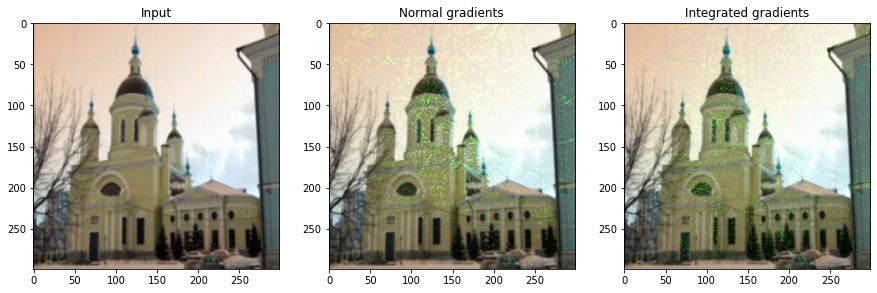

<ipython-input-10-d3e667082e47>:94: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  connected_components, num_comp = ndimage.measurements.label(


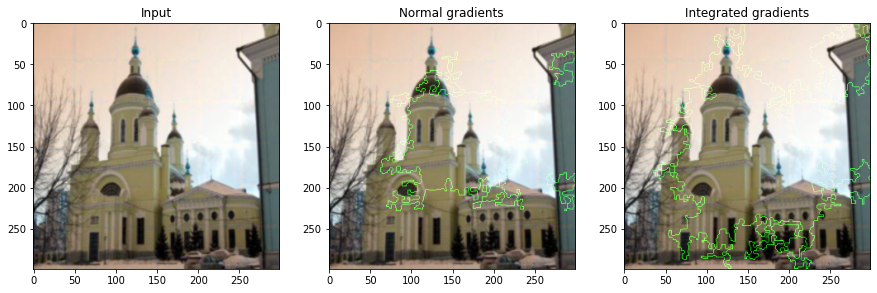

In [11]:
# 1. Convert the image to numpy array
img = get_img_array(img)

# 2. Keep a copy of the original image
orig_img = np.copy(img[0]).astype(np.uint8)

# 3. Preprocess the image
img_processed = tf.cast(xception.preprocess_input(img), dtype=tf.float32)

# 4. Get model predictions
preds = model.predict(img_processed)
top_pred_idx = tf.argmax(preds[0])
print("Predicted:", top_pred_idx, xception.decode_predictions(preds, top=1)[0])

# 5. Get the gradients of the last layer for the predicted label
grads = get_gradients(img_processed, top_pred_idx=top_pred_idx)

# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2
)

# 7. Process the gradients and plot
vis = GradVisualizer()
vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
)

vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=95,
    clip_below_percentile=28,
    morphological_cleanup=True,
    outlines=True,
)


1/1 [==============================] - 1s 663ms/step
Predicted: tf.Tensor(668, shape=(), dtype=int64) [('n03788195', 'mosque', 0.9722579)]


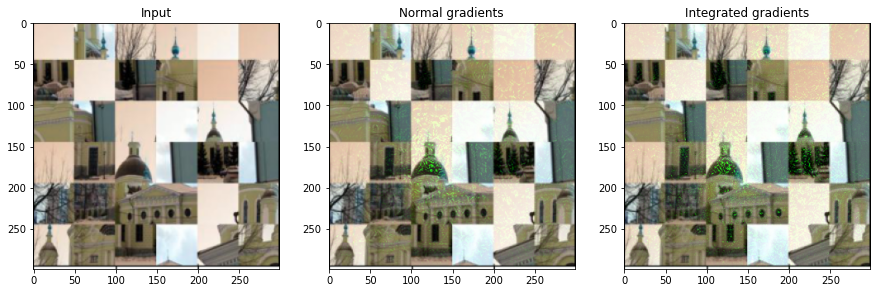

<ipython-input-10-d3e667082e47>:94: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  connected_components, num_comp = ndimage.measurements.label(


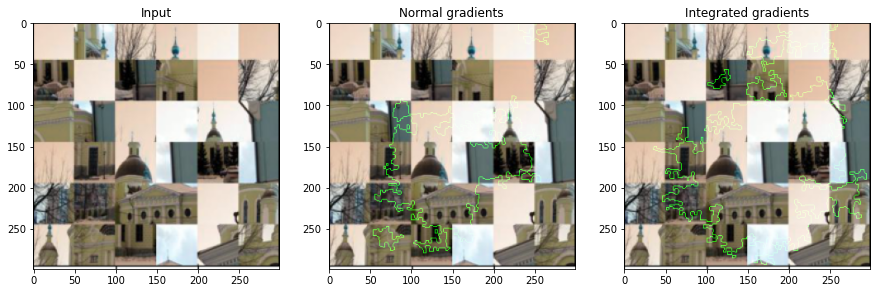

In [16]:
# 1. Convert the image to numpy array
img = get_img_array(img2)

# 2. Keep a copy of the original image
orig_img = np.copy(img[0]).astype(np.uint8)

# 3. Preprocess the image
img_processed = tf.cast(xception.preprocess_input(img), dtype=tf.float32)

# 4. Get model predictions
preds = model.predict(img_processed)
top_pred_idx = tf.argmax(preds[0])
print("Predicted:", top_pred_idx, xception.decode_predictions(preds, top=1)[0])

# 5. Get the gradients of the last layer for the predicted label
grads = get_gradients(img_processed, top_pred_idx=top_pred_idx)

# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2
)

# 7. Process the gradients and plot
vis = GradVisualizer()
vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
)

vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=95,
    clip_below_percentile=28,
    morphological_cleanup=True,
    outlines=True,
)
